In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This is derived from RunModel_Demo_02June2020-SimpleCNNLayer_Ca

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.

The 04Feb2021 version of the code is intended to train the same model, but using the KDE_A kernels rather than the original kernels.  The purpose is to test the code that reads in the KDE.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Thu Feb  4 15:46:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   43C    P2    68W / 250W |   1071MiB / 11019MiB |     32%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path


### Set up local parameters

In [4]:
n_epochs = 20

# Name is the output file name


##  190810  mds
folder = '04February2021_CNN5Layer_Ca_20epochs_poca_KDE_A'
name = '04February2021_CNN5Layer_Ca_20epochs_poca_KDE_A'

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 128

# How fast to learn
learning_rate = 3e-4

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
from model.collectdata_poca_KDE import collect_data_poca

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below


from model.models_mds_G import SimpleCNN5Layer_Ca as Model

from model.training import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 GeForce RTX 2080 Ti


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features

train_loader = collect_data_poca('/share/lazy/will/data/June30_2020_80k_1.h5',
                            batch_size=batch_size,
                            device=device,
                            masking=True, shuffle=True,
                           ## slice = slice(0,18000)
                           )

val_loader = collect_data_poca('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
                            device=device,
                            masking=True, shuffle=True,
                            ##slice = slice(18000,None)
                           )



Loading data...
Loaded /share/lazy/will/data/June30_2020_80k_1.h5 in 12.92 s
Constructing 80000 event dataset took 2.856 s
Loading data...
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 3.077 s
Constructing 20000 event dataset took 0.2287 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
model = Model()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

ct, child =  0    Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  1    Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  2    Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  3    Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  4    Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child =  5    Dropout(p=0.15, inplace=False)
ct, child =  6    Dropout(p=0.15, inplace=False)
ct, child =  7    Dropout(p=0.15, inplace=False)
ct, child =  8    Dropout(p=0.15, inplace=False)
ct, child =  9    Dropout(p=0.35, inplace=False)
ct, child =  10    Linear(in_features=4000, out_features=4000, bias=True)


In [11]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [12]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
pretrained_dict = torch.load('ML/02June2020_CNN5Layer_Ca_another200epochs_K/02June2020_CNN5Layer_Ca_another200epochs_K_final.pyt')
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
print(" \n","  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
## mds  

print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
## print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


output =  ML/04February2021_CNN5Layer_Ca_20epochs_poca_KDE_A
for model_dict
index, k =   0    conv1.weight
index, k =   1    conv1.bias
index, k =   2    conv2.weight
index, k =   3    conv2.bias
index, k =   4    conv3.weight
index, k =   5    conv3.bias
index, k =   6    conv4.weight
index, k =   7    conv4.bias
index, k =   8    conv5.weight
index, k =   9    conv5.bias
index, k =   10    fc1.weight
index, k =   11    fc1.bias
 
   for pretrained_dict
index, k =   0    conv1.weight
index, k =   1    conv1.bias
index, k =   2    conv2.weight
index, k =   3    conv2.bias
index, k =   4    conv3.weight
index, k =   5    conv3.bias
index, k =   6    conv4.weight
index, k =   7    conv4.bias
index, k =   8    conv5.weight
index, k =   9    conv5.bias
index, k =   10    fc1.weight
index, k =   11    fc1.bias
model_dict instantiated


<All keys matched successfully>

In [13]:
model = model.to(device)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


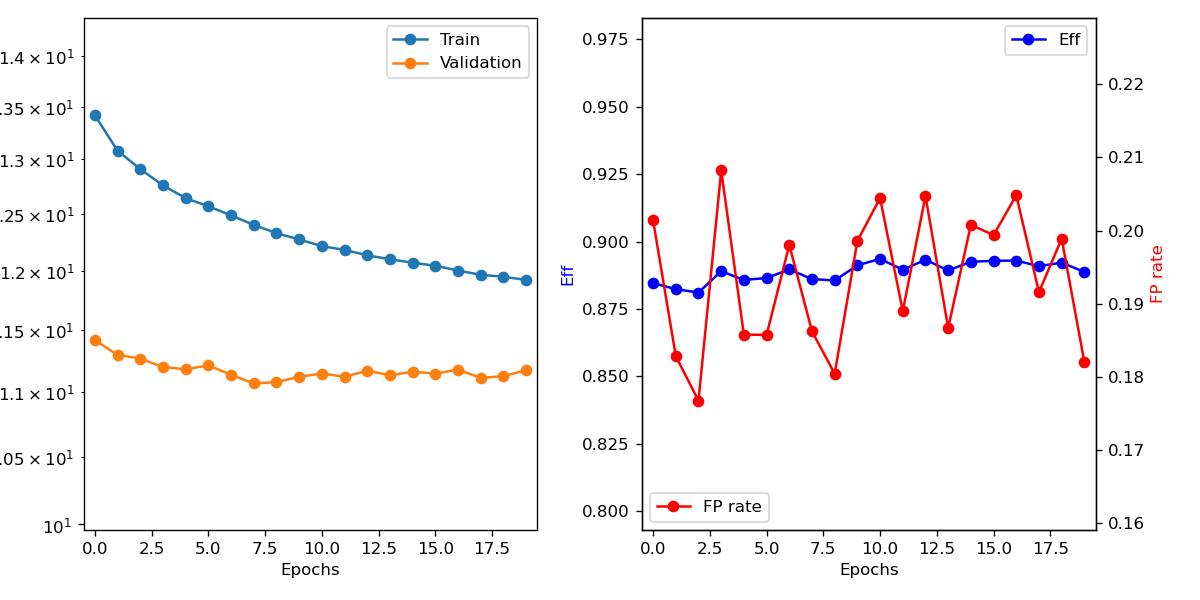

In [14]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [15]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 625, val = 157


Epoch 0: train=13.4155, val=11.4153, took 15.855 s
  Validation Found 95541 of 108007, added 4028 (eff 88.46%) (0.201 FP/event)


Epoch 1: train=13.0789, val=11.2954, took 15.824 s
  Validation Found 95297 of 108007, added 3657 (eff 88.23%) (0.183 FP/event)


Epoch 2: train=12.9073, val=11.2654, took 15.901 s
  Validation Found 95161 of 108007, added 3535 (eff 88.11%) (0.177 FP/event)


Epoch 3: train=12.7571, val=11.1974, took 16.048 s
  Validation Found 96017 of 108007, added 4165 (eff 88.90%) (0.208 FP/event)


Epoch 4: train=12.6408, val=11.1787, took 16.159 s
  Validation Found 95667 of 108007, added 3716 (eff 88.57%) (0.186 FP/event)


Epoch 5: train=12.5675, val=11.2105, took 16.307 s
  Validation Found 95743 of 108007, added 3715 (eff 88.65%) (0.186 FP/event)


Epoch 6: train=12.4854, val=11.1342, took 16.465 s
  Validation Found 96088 of 108007, added 3961 (eff 88.96%) (0.198 FP/event)


Epoch 7: train=12.4003, val=11.0664, took 16.645 s
  Validation Found 95701 of 108007, added 3725 (eff 88.61%) (0.186 FP/event)


Epoch 8: train=12.3271, val=11.0754, took 16.752 s
  Validation Found 95645 of 108007, added 3609 (eff 88.55%) (0.18 FP/event)


Epoch 9: train=12.2711, val=11.1193, took 16.801 s
  Validation Found 96252 of 108007, added 3972 (eff 89.12%) (0.199 FP/event)


Epoch 10: train=12.2125, val=11.1441, took 16.85 s
  Validation Found 96510 of 108007, added 4089 (eff 89.36%) (0.204 FP/event)


Epoch 11: train=12.18, val=11.1193, took 16.898 s
  Validation Found 96073 of 108007, added 3780 (eff 88.95%) (0.189 FP/event)


Epoch 12: train=12.1322, val=11.1672, took 17.034 s
  Validation Found 96477 of 108007, added 4095 (eff 89.32%) (0.205 FP/event)


Epoch 13: train=12.0979, val=11.1305, took 16.86 s
  Validation Found 96045 of 108007, added 3734 (eff 88.92%) (0.187 FP/event)


Epoch 14: train=12.0683, val=11.1599, took 16.917 s
  Validation Found 96393 of 108007, added 4016 (eff 89.25%) (0.201 FP/event)


Epoch 15: train=12.0416, val=11.144, took 16.852 s
  Validation Found 96433 of 108007, added 3988 (eff 89.28%) (0.199 FP/event)


Epoch 16: train=12.0007, val=11.1764, took 16.92 s
  Validation Found 96442 of 108007, added 4097 (eff 89.29%) (0.205 FP/event)


Epoch 17: train=11.9634, val=11.11, took 16.916 s
  Validation Found 96218 of 108007, added 3832 (eff 89.08%) (0.192 FP/event)


Epoch 18: train=11.9471, val=11.1239, took 16.49 s
  Validation Found 96359 of 108007, added 3978 (eff 89.22%) (0.199 FP/event)


Epoch 19: train=11.9201, val=11.1709, took 16.758 s
  Validation Found 95988 of 108007, added 3641 (eff 88.87%) (0.182 FP/event)



# Results

Let's save some results: (even though if you have not changed the code above, it saves the model every epoch)

Go ahead and save the final model (even though it was also saved above):

In [16]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [17]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['epoch', 'eff_val'], dtype='object')]

  encoding=encoding,


Save the plot above:

<IPython.core.display.Javascript object>


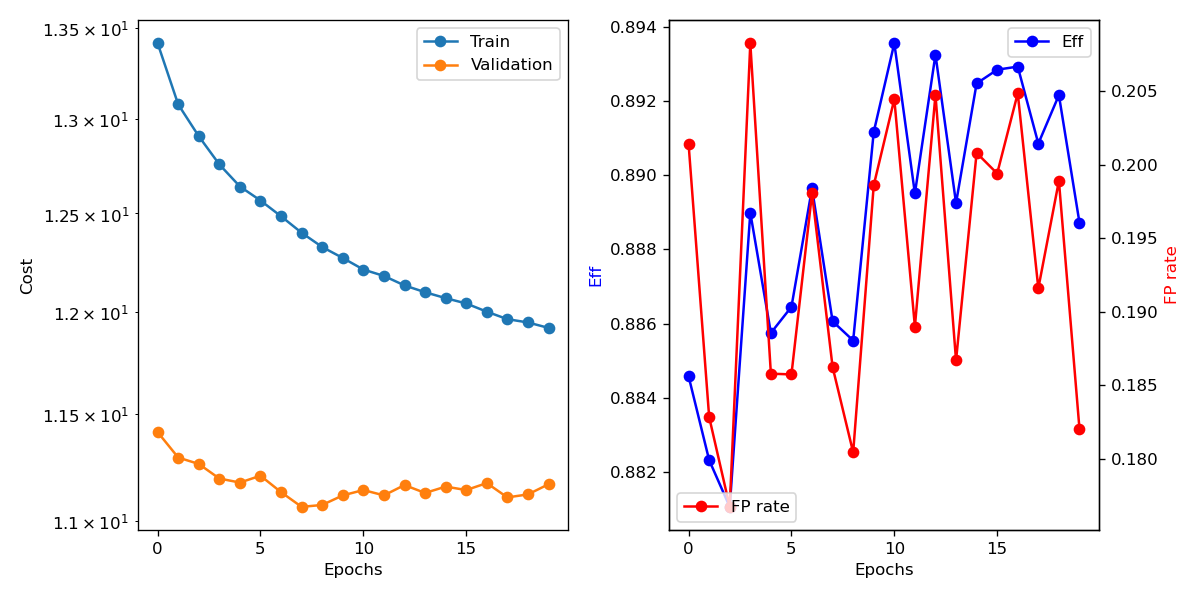

In [18]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [19]:
##quit()